# Learned iterative solver for CTscan imaging of FASTMRI brain dataset

### Author: M. Ravasi

Welcome to the "Deep Learning in Scientific Inverse Problems" course!

The aim of this fifth notebook is to train a Learned Iterative Solver to invert the CTscan imaging operator in a supervised manner. Similar to the previous example, we will be using a training dataset composed of several brain images and their corresponding FBP results for a CT aquisition with poor angle coverage. We wish to train a network to transform the FBP images into those of higher quality (assumed to be obtained using a a CT aquisition with better angle coverage), whilst using at the same time the knowledge of the acquisition system in the form of the gradient of the following data misfit norm: $ \Vert \mathbf{d}- \mathbf{G}\mathbf{x} \Vert_2^2$

The problem that we wish to solve can be expressed as:

$$
\underset{\theta} {\mathrm{argmin}} \; \Vert \mathbf{x}- f_\theta(\mathbf{x}_{FBP}) \Vert_2^2
$$

where $f_\theta$ is a deep unrolled network mimicking a proximal gradient descent algorithm (where the network acts the proximal operator)

In [1]:
#### COLAB ####
COLAB = False # Set to False or True depending if you use local or Colab env. (everything else will work automatically)

In [2]:
if COLAB:
    !apt-get install automake libtool
    !pip install astra-toolbox pylops pyproximal

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import astra
import numpy as np
import matplotlib.pyplot as plt
import pylops
import torch
import torch.nn as nn

from scipy.sparse.linalg import lsqr
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
from pylops import TorchOperator
from pylops.utils.dottest import dottest
from pylops.utils.metrics import snr
from pyproximal.proximal import *
from pyproximal.optimization.primal import *

from ct import CT2D
from learnedtrain import *
from learned import Learned
from plotting import plt_comparison
from utils import set_seed

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

set_seed(42)
    
# astra.test()

## Parameters

In [4]:
device = 'cpu' 
trainnet = True # True: run training, False: load pre-trained network

# Training parameters (used only when trainnet=True)
nsamples = 500 # to speed up training (given the cost of this method), total number of samples is 1380
batch_size = 64
niter = 5
n_epochs = 30
lr = 1e-3

## Load training dataset

In [5]:
# Load data
if not COLAB:
    f = np.load('../data/brains_fbp_trainingdata.npz')
else:
    f = np.load('/content/drive/My Drive/DA_SummerSchool_2023/brains_fbp_trainingdata.npz')
brains = f['brains'][:nsamples] 
brainsfbp = f['fbps'][:nsamples]
sinograms = f['sinograms'][:nsamples]
nx, ny = brains.shape[1:]

# Remove 10th element, always used to test different imaging algorithm
brain_test = brains[10]
brainfbp_test = brainsfbp[10]
sinogram_test = sinograms[10]
brains = np.delete(brains, 10, axis=0)
brainsfbp = np.delete(brainsfbp, 10, axis=0)
sinograms = np.delete(sinograms, 10, axis=0);

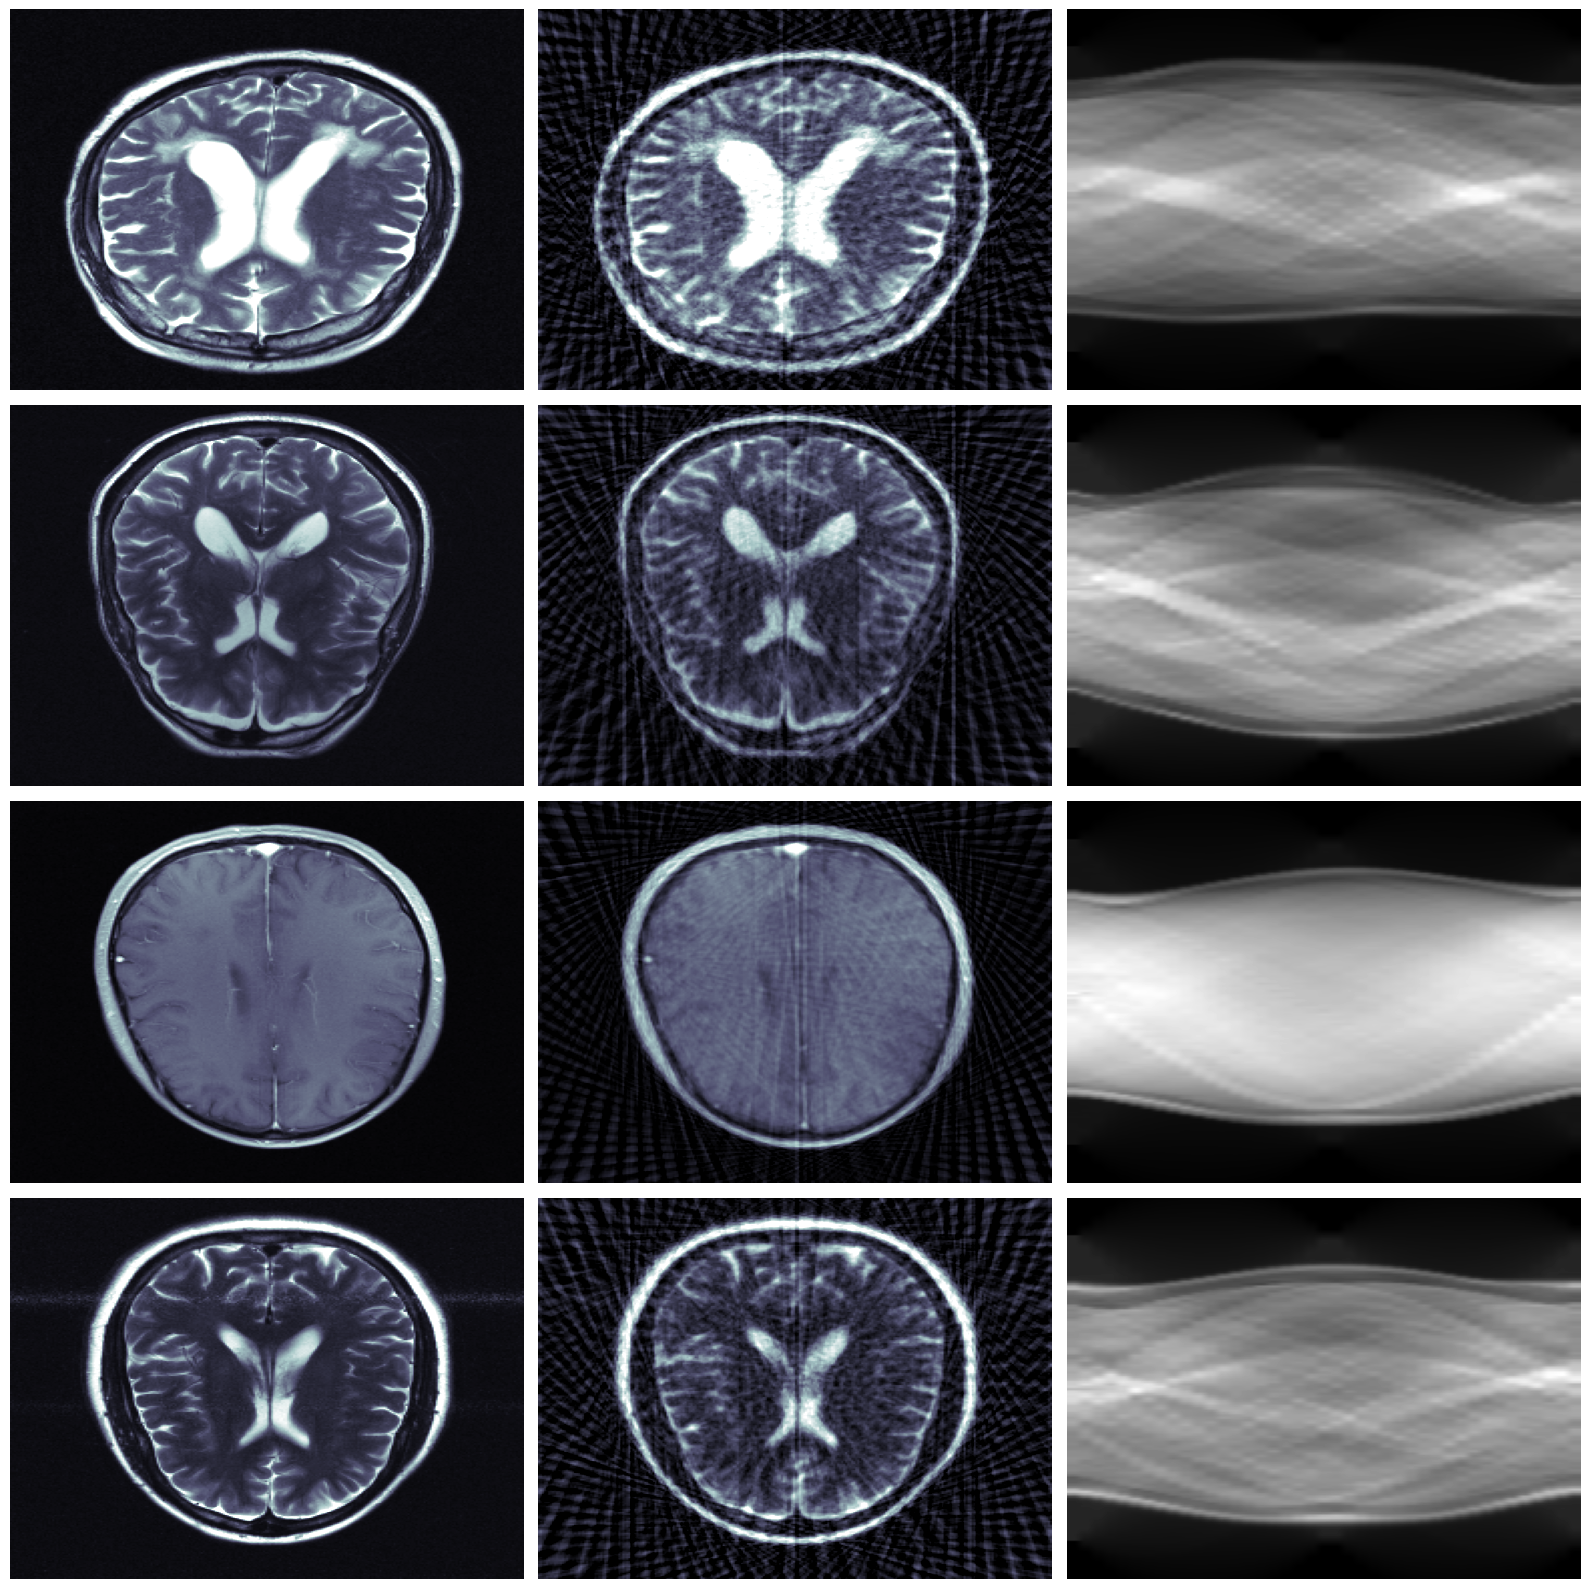

In [6]:
iimages = np.random.randint(0, len(brains), 4)
fig, axs = plt.subplots(4, 3, figsize=(16, 16))

for iax, iimage in enumerate(iimages):
    axs[iax, 0].imshow(brains[iimage], cmap="bone", vmin=0, vmax=.7)
    axs[iax, 0].axis("tight")
    axs[iax, 0].axis("off")
    axs[iax, 1].imshow(brainsfbp[iimage], cmap="bone", vmin=0, vmax=.7)
    axs[iax, 1].axis("off")
    axs[iax, 1].axis("tight")
    axs[iax, 2].imshow(sinograms[iimage].T, cmap="gray")
    axs[iax, 2].axis("off")
    axs[iax, 2].axis("tight")
plt.tight_layout()

In [7]:
# Create operator
nangles = 41
distdetectors = 2
ndetectors = 160

Cop = CT2D((nx, ny), distdetectors, ndetectors, np.linspace(0, np.pi, nangles, False))
Cop_torch = TorchOperator(Cop, batch=False)

dottest(Cop, atol=1e-3, verb=True);

Dot test passed, v^H(Opu)=201.80618634112398 - u^H(Op^Hv)=201.80653578046253


True


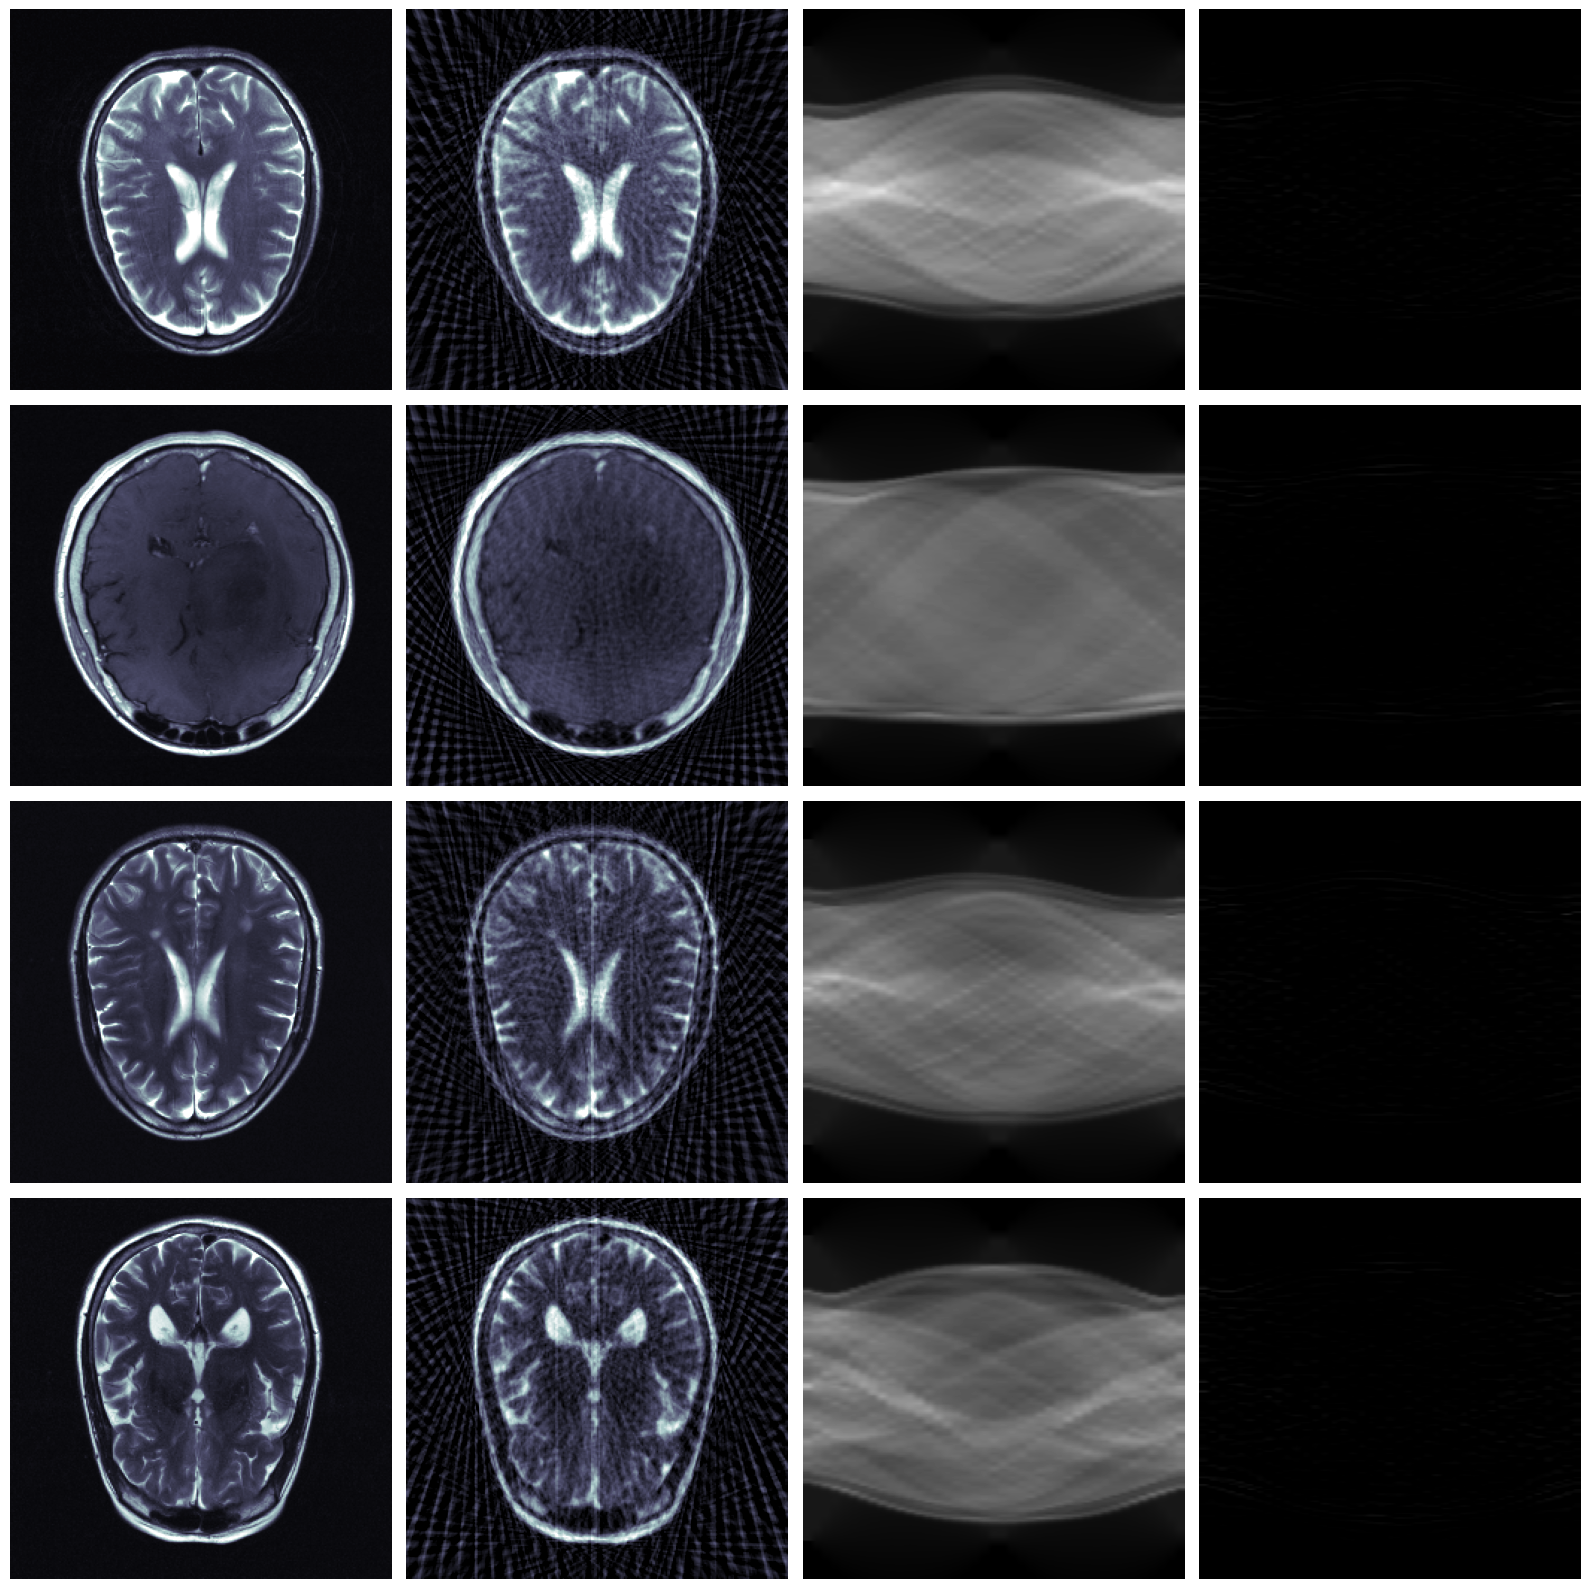

In [8]:
# Test that operator produces the same data as the one pre-computed and loaded from file
print(np.allclose(sinogram_test, Cop @ brain_test))

iimages = np.random.randint(0, len(brains), 4)
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for iax, iimage in enumerate(iimages):
    axs[iax, 0].imshow(brains[iimage], cmap="bone", vmin=0, vmax=.7)
    axs[iax, 0].axis("tight")
    axs[iax, 0].axis("off")
    axs[iax, 1].imshow(brainsfbp[iimage], cmap="bone", vmin=0, vmax=.7)
    axs[iax, 1].axis("off")
    axs[iax, 1].axis("tight")
    axs[iax, 2].imshow(sinograms[iimage].T, cmap="gray", vmin=0, vmax=1e2)
    axs[iax, 2].axis("off")
    axs[iax, 2].axis("tight")
    axs[iax, 3].imshow(sinograms[iimage].T-(Cop @ brainsfbp[iimage]).T, cmap="gray", vmin=0, vmax=1e2)
    axs[iax, 3].axis("off")
    axs[iax, 3].axis("tight")
plt.tight_layout()

In [9]:
# Create train/validation set
X0_train, X0_valid, Y_train, Y_valid, X_train, X_valid = train_test_split(brainsfbp, brains, sinograms, 
                                                                          test_size=0.2, random_state=42)

In [10]:
# Convert Train Set to Torch
X0_train = torch.from_numpy(X0_train).float().unsqueeze(1)
X_train = torch.from_numpy(X_train).float().unsqueeze(1)
Y_train = torch.from_numpy(Y_train).float().unsqueeze(1)
train_dataset = TensorDataset(X0_train, X_train, Y_train)

# Define Valid Set to Torch
X0_valid = torch.from_numpy(X0_valid).float().unsqueeze(1)
X_valid = torch.from_numpy(X_valid).float().unsqueeze(1)
Y_valid = torch.from_numpy(Y_valid).float().unsqueeze(1)
valid_dataset = TensorDataset(X0_valid, X_valid, Y_valid)

# Create DataLoaders fixing the generator for reproducibily
g = torch.Generator()
g.manual_seed(42)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [11]:
network = Learned(2, 16, 1, niter, Cop_torch)
summary(network.net, input_size=(1, 2, nx, ny)) 
network.to(device) # summary will automatically move weights to cuda:0, need to move back to actual chosen device

Learned(
  (net): ResUNet(
    (first): ResNetBlock(
      (blocks): Sequential(
        (0): Sequential(
          (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (shortcut): Sequential(
        (0): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (accfun): LeakyReLU(negative_slope=0.2, inplace=True)
      (bnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (contracts): Sequential(
      (0): C

In [12]:
if trainnet:
    criterion = nn.MSELoss()
    optim = torch.optim.Adam(network.parameters(), lr=lr)

    train_loss_history = np.zeros(n_epochs)
    valid_loss_history = np.zeros(n_epochs)

    for epoch in range(n_epochs):
        train_loss = train(network, criterion, optim, 
                           train_loader, device=device)
        valid_loss = evaluate(network, criterion, 
                              valid_loader, device=device)
        train_loss_history[epoch] = train_loss
        valid_loss_history[epoch] = valid_loss
        
        print(f'Epoch {epoch}, Training Loss {train_loss:.4f}, Valid Loss {valid_loss:.4f}')

    # Save model
    torch.save(network.state_dict(), '../models/Learned.pt')

else:   
    criterion = nn.MSELoss()
    
    # Load model
    network.load_state_dict(torch.load('../models/Learned.pt'))    

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Training Loss 1.3021, Valid Loss 0.5423


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, Training Loss 0.4501, Valid Loss 0.3441


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2, Training Loss 0.2895, Valid Loss 0.2206


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3, Training Loss 0.1811, Valid Loss 0.1341


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4, Training Loss 0.1087, Valid Loss 0.0782


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5, Training Loss 0.0623, Valid Loss 0.0440


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6, Training Loss 0.0357, Valid Loss 0.0284


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7, Training Loss 0.0235, Valid Loss 0.0205


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8, Training Loss 0.0206, Valid Loss 0.0197


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9, Training Loss 0.0189, Valid Loss 0.0194


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10, Training Loss 0.0203, Valid Loss 0.0176


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11, Training Loss 0.0155, Valid Loss 0.0138


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12, Training Loss 0.0129, Valid Loss 0.0119


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13, Training Loss 0.0109, Valid Loss 0.0101


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14, Training Loss 0.0096, Valid Loss 0.0092


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15, Training Loss 0.0089, Valid Loss 0.0087


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16, Training Loss 0.0083, Valid Loss 0.0081


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17, Training Loss 0.0085, Valid Loss 0.0089


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18, Training Loss 0.0090, Valid Loss 0.0082


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19, Training Loss 0.0079, Valid Loss 0.0071


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20, Training Loss 0.0068, Valid Loss 0.0066


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21, Training Loss 0.0067, Valid Loss 0.0067


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22, Training Loss 0.0067, Valid Loss 0.0065


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23, Training Loss 0.0066, Valid Loss 0.0066


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24, Training Loss 0.0061, Valid Loss 0.0062


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25, Training Loss 0.0060, Valid Loss 0.0060


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26, Training Loss 0.0058, Valid Loss 0.0059


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27, Training Loss 0.0056, Valid Loss 0.0056


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28, Training Loss 0.0057, Valid Loss 0.0055


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29, Training Loss 0.0053, Valid Loss 0.0052


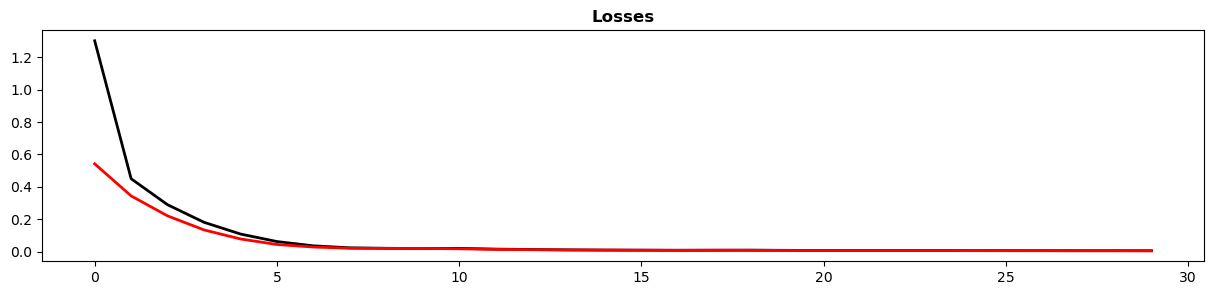

In [13]:
if trainnet:
    fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    ax.plot(train_loss_history, 'k', lw=2, label='Train')
    ax.plot(valid_loss_history, 'r', lw=2, label='Valid')
    ax.set_title('Losses', fontweight='bold');

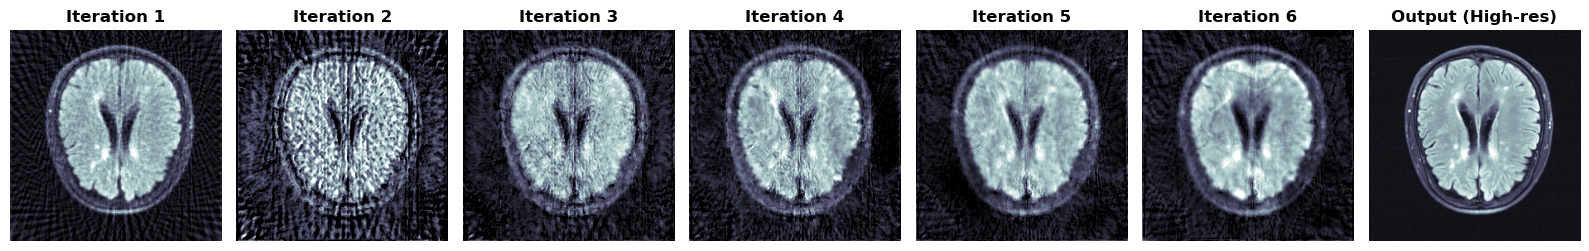

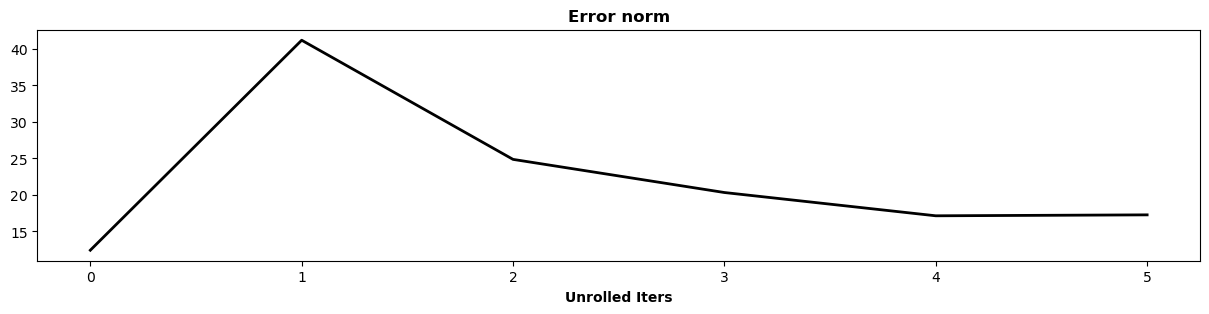

In [14]:
# Training predictions
iimage = 12
Y_train_pred, _ = network.forward_sequence(X0_train[iimage], X_train[iimage], Y_train[iimage], criterion)
loss_train = [np.linalg.norm(Y_train[iimage].ravel() - y.ravel()) for y in Y_train_pred]

fig, axs = plt.subplots(1, niter + 2, sharex=True, sharey=True, figsize=(16, 16))
axs[-1].imshow(Y_train[iimage].squeeze(), cmap="bone", vmin=0, vmax=.7)
axs[-1].axis("off")
for iax in range(niter+1):
    axs[iax].imshow(Y_train_pred[iax], cmap="bone", vmin=0, vmax=.7)
    axs[iax].axis("off")
    axs[iax].set_title(f"Iteration {iax+1}", fontweight="bold")
axs[-1].set_title("Output (High-res)", fontweight="bold")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(loss_train, 'k', lw=2)
ax.set_xlabel('Unrolled Iters', fontweight='bold')
ax.set_title('Error norm', fontweight='bold');

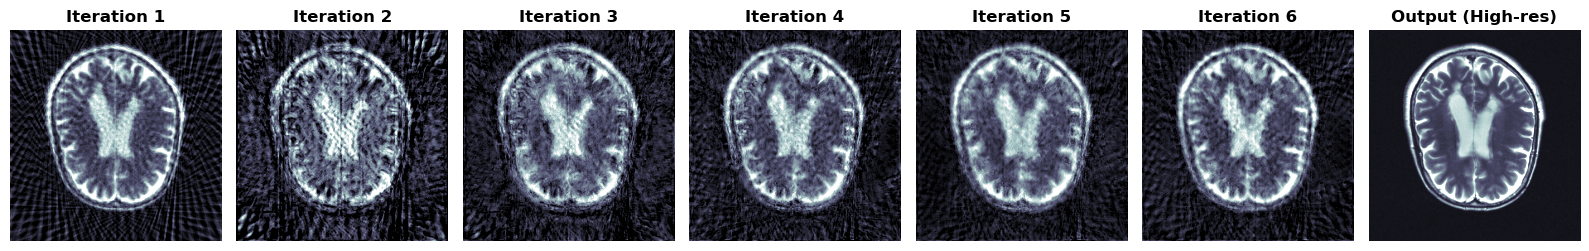

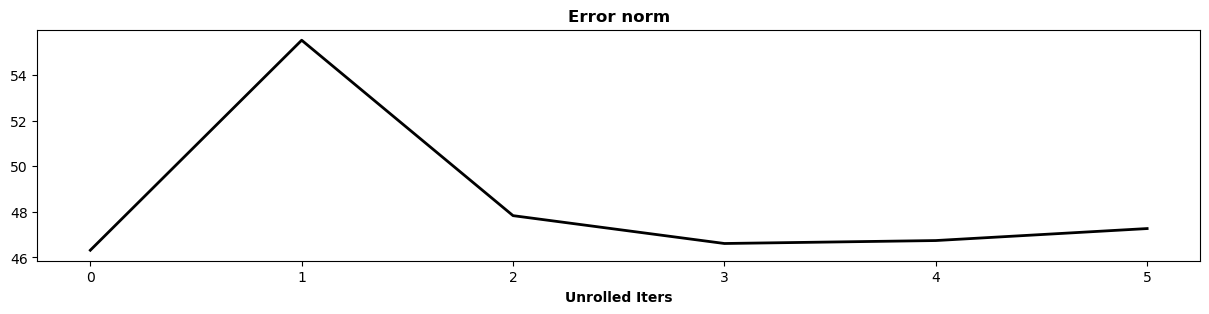

In [15]:
# Validation predictions
iimage = 0
Y_valid_pred, _ = network.forward_sequence(X0_valid[iimage], X_valid[iimage], Y_valid[iimage], criterion)
loss_valid = [np.linalg.norm(Y_valid[iimage].ravel() - y.ravel()) for y in Y_train_pred]

fig, axs = plt.subplots(1, niter + 2, sharex=True, sharey=True, figsize=(16, 16))
axs[-1].imshow(Y_valid[iimage].squeeze(), cmap="bone", vmin=0, vmax=.7)
axs[-1].axis("off")
for iax in range(niter+1):
    axs[iax].imshow(Y_valid_pred[iax], cmap="bone", vmin=0, vmax=.7)
    axs[iax].axis("off")
    axs[iax].set_title(f"Iteration {iax+1}", fontweight="bold")
axs[-1].set_title("Output (High-res)", fontweight="bold")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(loss_valid, 'k', lw=2)
ax.set_xlabel('Unrolled Iters', fontweight='bold')
ax.set_title('Error norm', fontweight='bold');

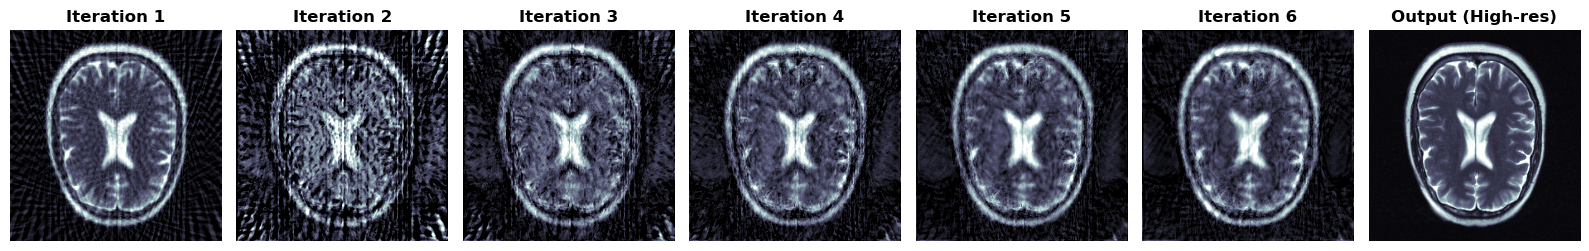

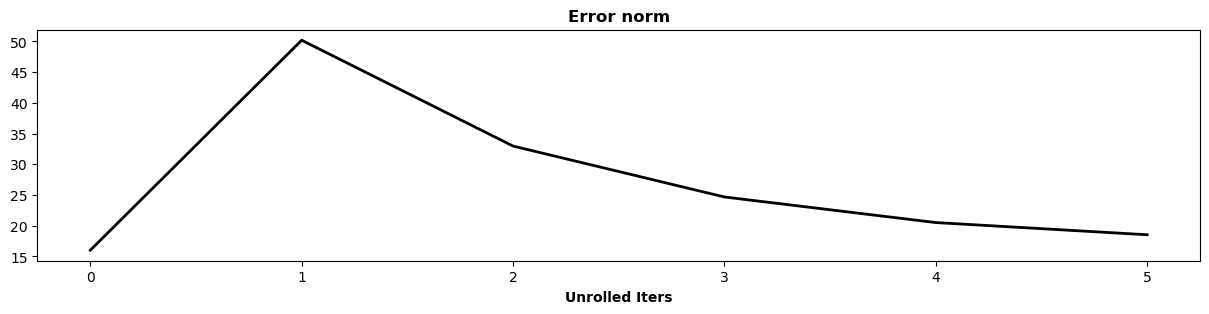

In [16]:
# Test prediction
brain_testpred, _ = network.forward_sequence(torch.from_numpy(brainfbp_test).unsqueeze(0), 
                                             torch.from_numpy(sinogram_test).unsqueeze(0), 
                                             torch.from_numpy(brain_test).unsqueeze(0), criterion)
loss_test = [np.linalg.norm(brain_test.ravel() - y.ravel()) for y in brain_testpred]

fig, axs = plt.subplots(1, niter + 2, sharex=True, sharey=True, figsize=(16, 16))
axs[-1].imshow(brain_test, cmap="bone", vmin=0, vmax=.7)
axs[-1].axis("off")
for iax in range(niter+1):
    axs[iax].imshow(brain_testpred[iax], cmap="bone", vmin=0, vmax=.7)
    axs[iax].axis("off")
    axs[iax].set_title(f"Iteration {iax+1}", fontweight="bold")
axs[-1].set_title("Output (High-res)", fontweight="bold")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(loss_test, 'k', lw=2)
ax.set_xlabel('Unrolled Iters', fontweight='bold')
ax.set_title('Error norm', fontweight='bold');

/home/ravasim/Documents/2023/Teaching/DA_summerschool_2023/notebooks/plotting.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


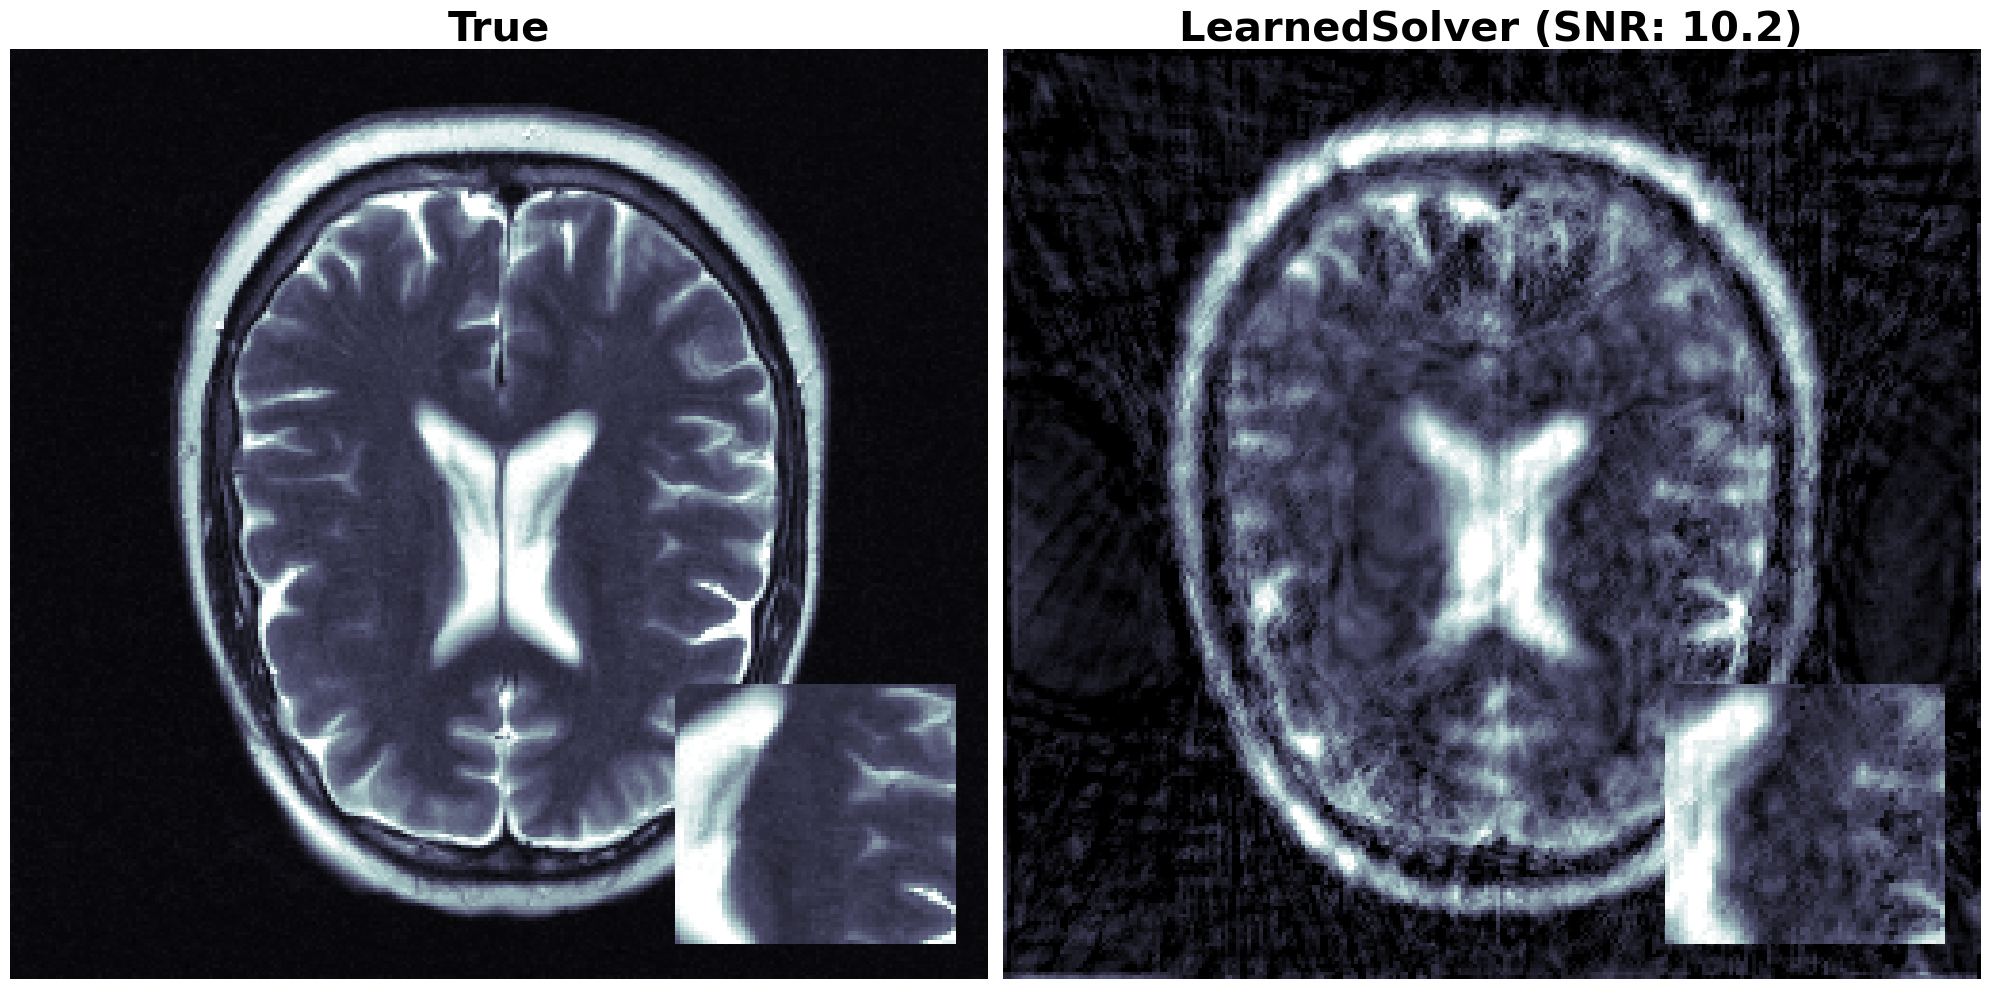

In [17]:
plt_comparison(brain_test, brain_testpred[-1], cmap='bone', clim=(0, 0.7), 
               titles=['True', 'LearnedSolver'], zoom=(100, 160, 130, 190),
               metricname='SNR', metric=snr)